### QC Data Generation for musical counterpoint:

Trotterized Time evolution of a Transverse Field Ising Model, as a simulated Quantum Circuit.
The Ising Model hamiltonian terms are dynamic and determined by the ECoG dataset drawn from patient 02 of the *Fragility Multi-Center Retrospective Study* ([link](https://openneuro.org/datasets/ds003029/versions/1.0.6)), with the data mapping implemented below.

**Disclaimer** The ECoG dataset is part of an extensive past study, adopted in other research regarding epilepsy by some co-authors. However, the same approach in this work can also be achieved by using non-invasive data

Acknowledgement: Parts of this code were inherited from the QC-PAINT project, and adapted to this context



--> [https://doi.org/10.5281/zenodo.14136712](https://doi.org/10.5281/zenodo.14136712) <--


In [3]:
import numpy as np
import math
from math import acos
import os
import re

import qiskit
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import Pauli, SparsePauliOp


from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator, SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt
from tqdm import tqdm
service = QiskitRuntimeService()

In [4]:
from pathlib import Path

def list_filenames(folder_path):
    """
    Returns a list of file names (not directories) in the given folder.
    """
    folder = Path(folder_path)
    return [folder_path + p.name for p in folder.iterdir() if p.is_file()]


def get_channel_names(file_paths):
    chnames=[]
    for fpath in file_paths:
        chnames.append(fpath.split('/')[-1].split('_')[0])
    return chnames

In [5]:
patientID = 1

datapath = f'channels_for_sonification/patient{patientID}/'
file_paths = list_filenames(datapath)
channel_names = get_channel_names(file_paths)
print(file_paths)
print(channel_names)

['channels_for_sonification/patient1/TT1_no_first.txt', 'channels_for_sonification/patient1/MST4_no_first.txt', 'channels_for_sonification/patient1/TT4_no_first.txt', 'channels_for_sonification/patient1/MST2_no_first.txt', 'channels_for_sonification/patient1/AST1_no_first.txt', 'channels_for_sonification/patient1/PST1_no_first.txt', 'channels_for_sonification/patient1/TT2_no_first.txt', 'channels_for_sonification/patient1/TT6_no_first.txt', 'channels_for_sonification/patient1/PST3_no_first.txt', 'channels_for_sonification/patient1/TT3_no_first.txt', 'channels_for_sonification/patient1/MST1_no_first.txt', 'channels_for_sonification/patient1/PST2_no_first.txt', 'channels_for_sonification/patient1/PST4_no_first.txt', 'channels_for_sonification/patient1/MST3_no_first.txt', 'channels_for_sonification/patient1/TT5_no_first.txt', 'channels_for_sonification/patient1/AST2_no_first.txt']
['TT1', 'MST4', 'TT4', 'MST2', 'AST1', 'PST1', 'TT2', 'TT6', 'PST3', 'TT3', 'MST1', 'PST2', 'PST4', 'MST3', '

In [6]:
channel=0
a4s = []
for channel in range(len(channel_names)):
    print(channel_names[channel])
    
    a4 = np.loadtxt(f'computed_sonification_data/patient{patientID}_quantum_rolling_a4_{channel_names[channel]}.txt', skiprows=1)
    a4 = a4[:,1]
    a4s.append(a4)

TT1
MST4
TT4
MST2
AST1
PST1
TT2
TT6
PST3
TT3
MST1
PST2
PST4
MST3
TT5
AST2


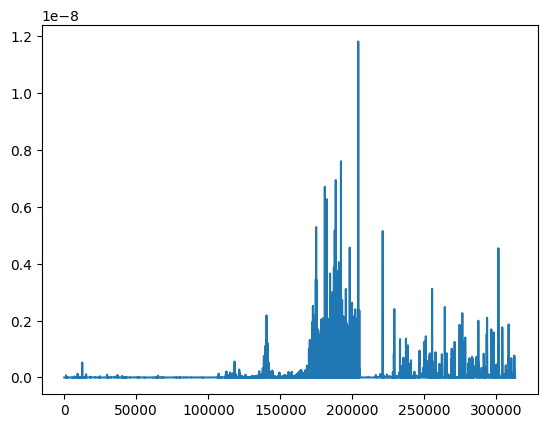

In [7]:
plt.plot(a4s[0])
plt.show()

In [8]:
len(a4)

313093

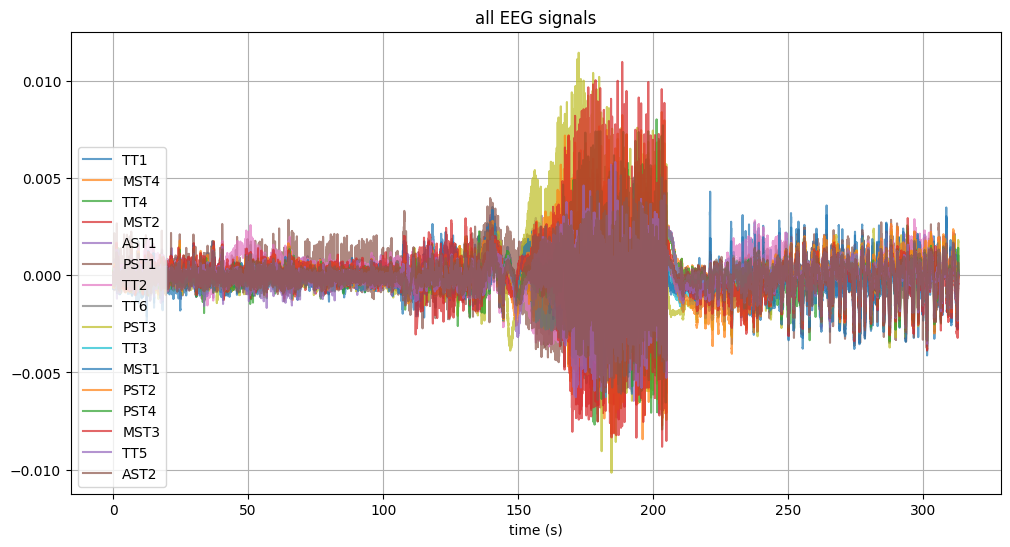

In [9]:

data = []
# filenames = []
for file in file_paths:
    # filenames.append(file)
    # file_path = os.path.join(folder_path, file)
    dataset = np.loadtxt(file, skiprows=1)

    data.append(dataset)

plt.figure(figsize=(12, 6))

for i, datensatz in enumerate(data):
    time = datensatz[:, 0]
    signal = datensatz[:, 1]
    plt.plot(time, signal, label=f'{channel_names[i]}', alpha=0.7)

plt.title("all EEG signals")
plt.xlabel("time (s)")
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [10]:
for i, d in enumerate(data):
    print(f"Datensatz {i+1}: Shape {d.shape}")

min_len = min(d.shape[0] for d in data)
signals_only = np.array([d[:min_len, 1] for d in data])  # keep only signal vector, omit time vector
times_only = np.array([d[:min_len, 0] for d in data])
print('size of the whole data matrix: ', signals_only.shape)  

Datensatz 1: Shape (313110, 2)
Datensatz 2: Shape (313110, 2)
Datensatz 3: Shape (313110, 2)
Datensatz 4: Shape (313110, 2)
Datensatz 5: Shape (313110, 2)
Datensatz 6: Shape (313110, 2)
Datensatz 7: Shape (313110, 2)
Datensatz 8: Shape (313111, 2)
Datensatz 9: Shape (313110, 2)
Datensatz 10: Shape (313110, 2)
Datensatz 11: Shape (313110, 2)
Datensatz 12: Shape (313110, 2)
Datensatz 13: Shape (313110, 2)
Datensatz 14: Shape (313110, 2)
Datensatz 15: Shape (313111, 2)
Datensatz 16: Shape (313110, 2)
size of the whole data matrix:  (16, 313110)


# Transverse field $h_x$

In [11]:
steps = 30

In [12]:
def tag_seizure_onset(roll, thresh):
    diff = roll-np.roll(roll, 1)>thresh
    idx = np.flatnonzero(diff)
    return diff, np.flatnonzero(diff)[0] if idx.size > 0 else None

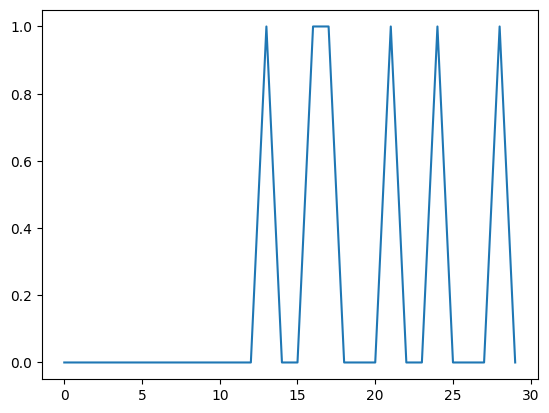

13


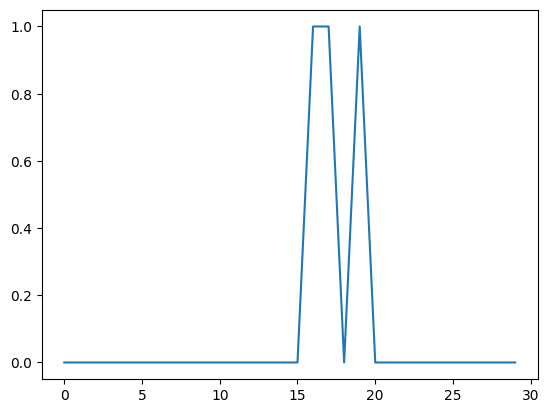

16


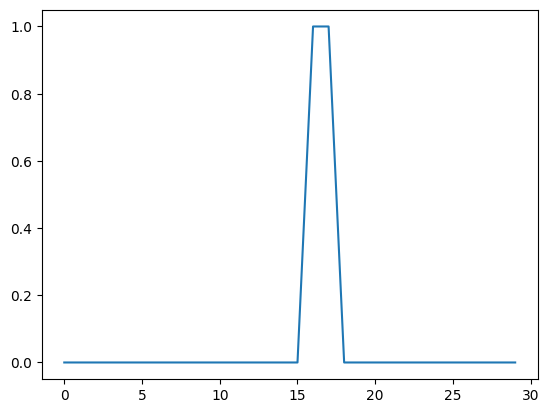

16


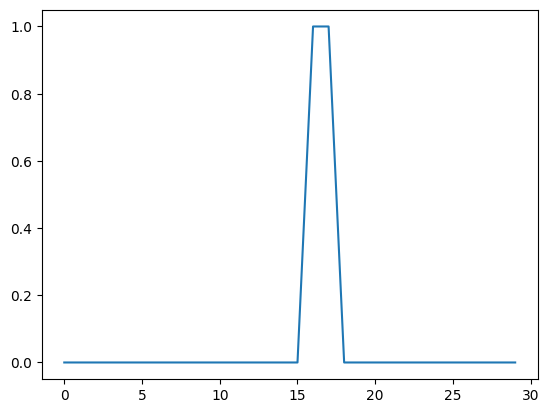

16


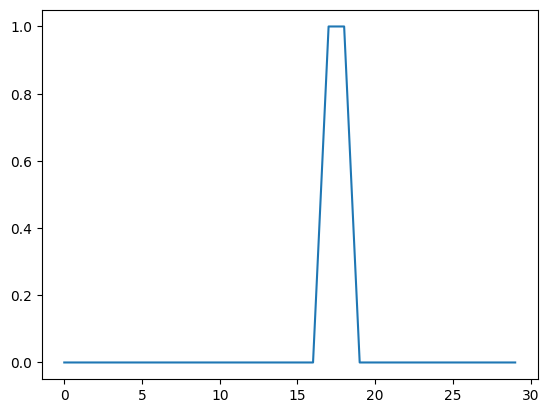

17


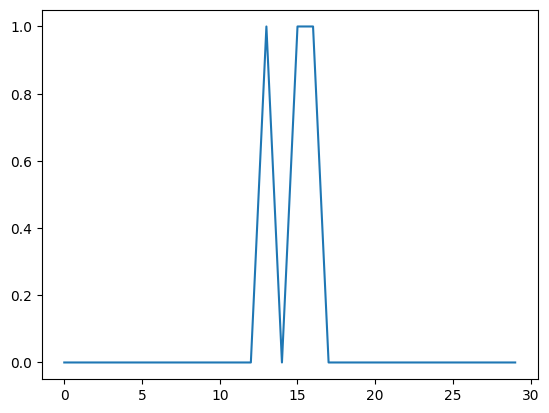

13


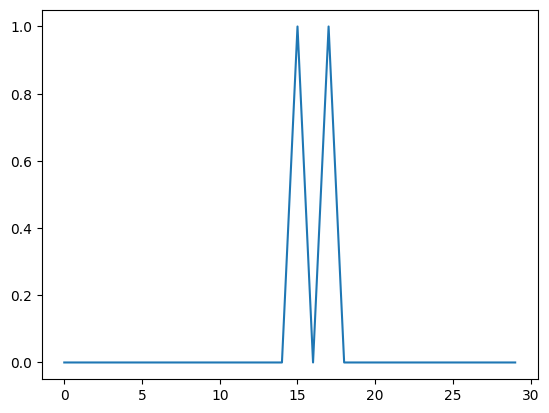

15


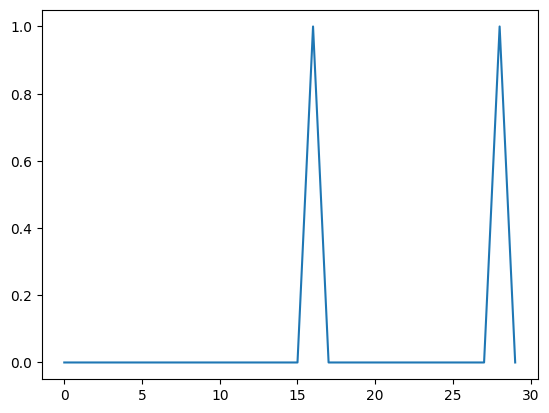

16


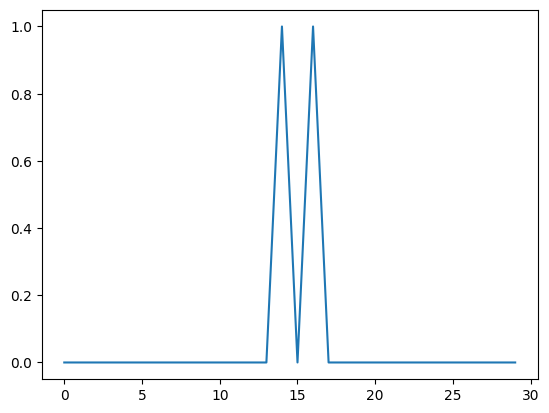

14


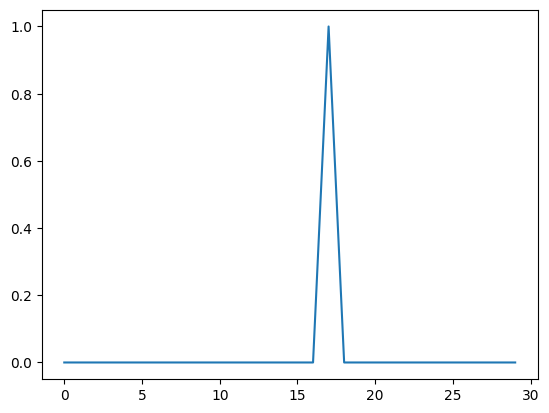

17


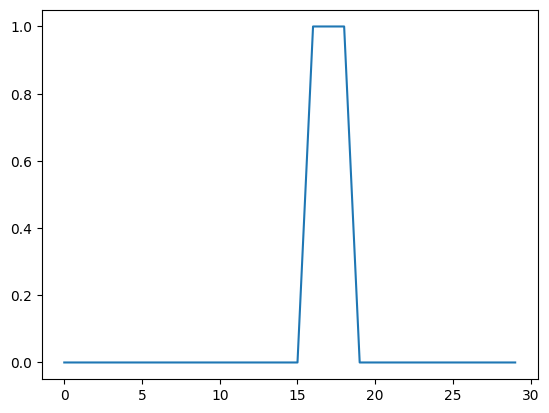

16


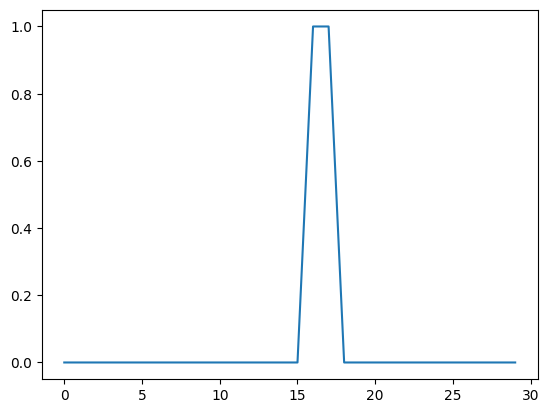

16


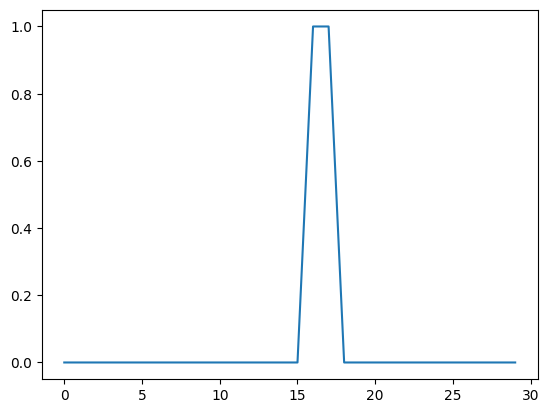

16


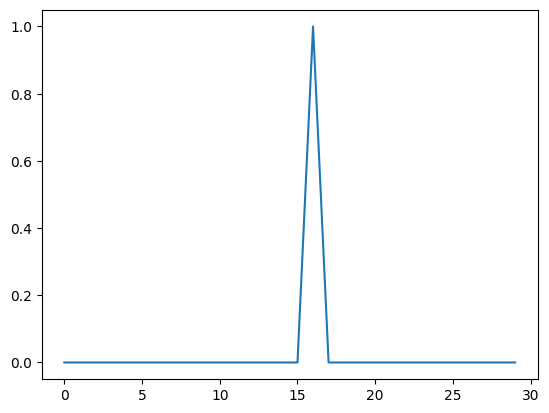

16


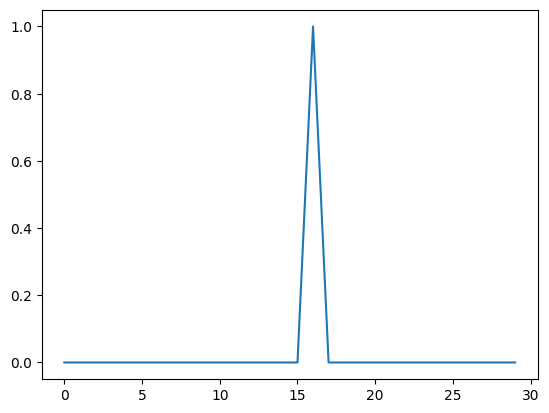

16


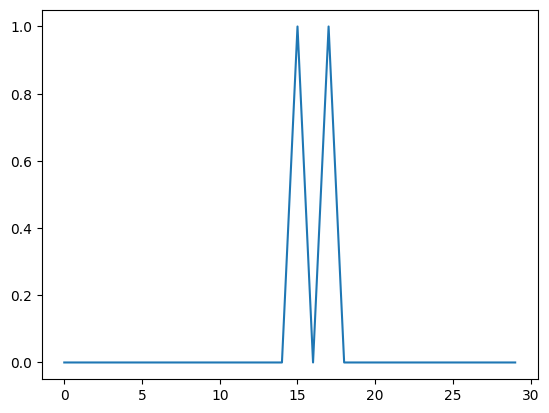

15


In [13]:

rolls=[]

step_length = len(a4)//(steps)
for j in range(signals_only.shape[0]):
    roll=[]
    a4 = a4s[j]
    for i, time in enumerate(range(0,len(a4) - step_length, step_length)):
        
        vector = a4[time:time+step_length]
        vector_norm = np.linalg.norm(vector)  # if we do it quantum, we need to normalize the vector but save the norm so that we can rescale
        if vector_norm == 0:
            roll.append(0)
            continue
        vector = vector / vector_norm
        classical_sum4 = np.sum(vector)
        roll.append(classical_sum4* vector_norm)
    
    roll = np.array(roll)
    roll = (roll/np.linalg.norm(roll))
    diff, idx = tag_seizure_onset(roll, 0.1)
    if idx:
        plt.plot(diff)
        plt.show()
        print(idx)
    
    else: 
        print(idx)
    
    # print(idx)
    if idx:
        roll /= roll[idx]# roll[4] is at the phase transition
    roll = np.array(roll)
    rolls.append(roll)
rolls = np.array(rolls)

In [103]:
def plot_roll(rolls, channel):

    plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 22,
    "axes.labelsize": 20,
    "axes.titlesize": 22,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "axes.linewidth": 2.2
    })
    roll = np.array(rolls[channel])
    
    fig, ax = plt.subplots(figsize=(14,5))
    
    # ax.plot(np.arange(len(roll)), roll, linewidth=2)
    ax.plot(np.arange(len(roll)), roll, linewidth=3.0, alpha=0.9, solid_joinstyle="round")

    
    ax.set_ylabel("renormalized value")
    ax.set_title(rf'Grouped $\sum a_i^4$ of rolling ranges of {channel_names[channel]}')
    
    step_ticks = np.arange(0, len(roll), 3)
    
    ax.set_xticks(step_ticks)
    
    time_labels = times_only[0][(step_ticks * step_length).astype(int)]
    ax.set_xticklabels([f"{t:.1f}" for t in time_labels])
    ax.set_xlabel("time [s]")
    
    ax.grid(True, alpha=0.25)
    
    
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(step_ticks)
    ax2.set_xticklabels([str(int(s)) for s in step_ticks])
    # ax2.tick_params(axis="x", labelsize=11, pad=4, length=3)
    # ax2.spines["top"].set_alpha(0.4)
    # ax2.spines["top"].set_linewidth(1.0)

    ax2.set_xlabel("step index")
    
    plt.tight_layout()
    plt.show()


In [106]:
def plot_roll_grouped(rolls, normalize=True):

    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": 22,
        "axes.labelsize": 20,
        "axes.titlesize": 22,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "axes.linewidth": 2.2
    })

    fig, ax = plt.subplots(figsize=(14, 5))

    for ch in range(len(rolls)):
        roll = np.array(rolls[ch])

        if normalize:
            roll = (roll - np.mean(roll)) / (np.std(roll) + 1e-12)

        ax.plot(
            np.arange(len(roll)),
            roll,
            linewidth=2.5,
            alpha=0.55,
            solid_joinstyle="round",
            label=channel_names[ch]
        )

    ax.set_ylabel("renormalized value" if normalize else "value")
    ax.set_title(r"Grouped $\sum a_i^4$ of rolling ranges (all channels)")

    step_ticks = np.arange(0, len(roll), 3)
    ax.set_xticks(step_ticks)

    time_labels = times_only[0][(step_ticks * step_length).astype(int)]
    ax.set_xticklabels([f"{t:.1f}" for t in time_labels])
    ax.set_xlabel("time [s]")

    ax.grid(True, alpha=0.25)

    # top axis: step index
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(step_ticks)
    ax2.set_xticklabels([str(int(s)) for s in step_ticks])
    ax2.set_xlabel("step index")

    # legend (optional, can be too large)
    ax.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False,
        fontsize=14
    )

    plt.tight_layout()
    plt.show()


# Coupling Coefficients J

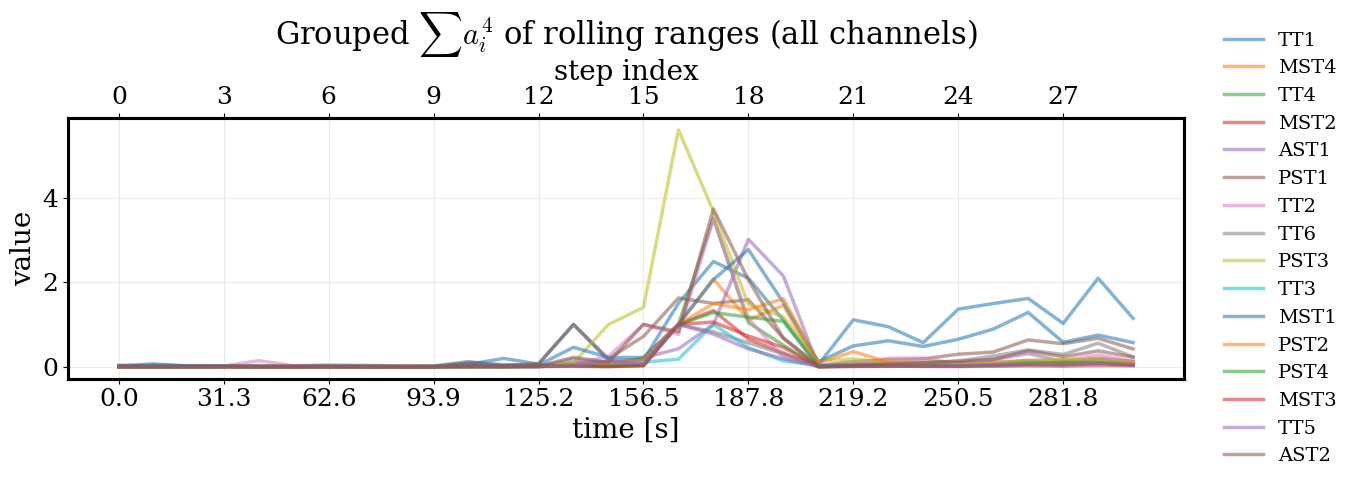

In [108]:
plot_roll_grouped(rolls, False)

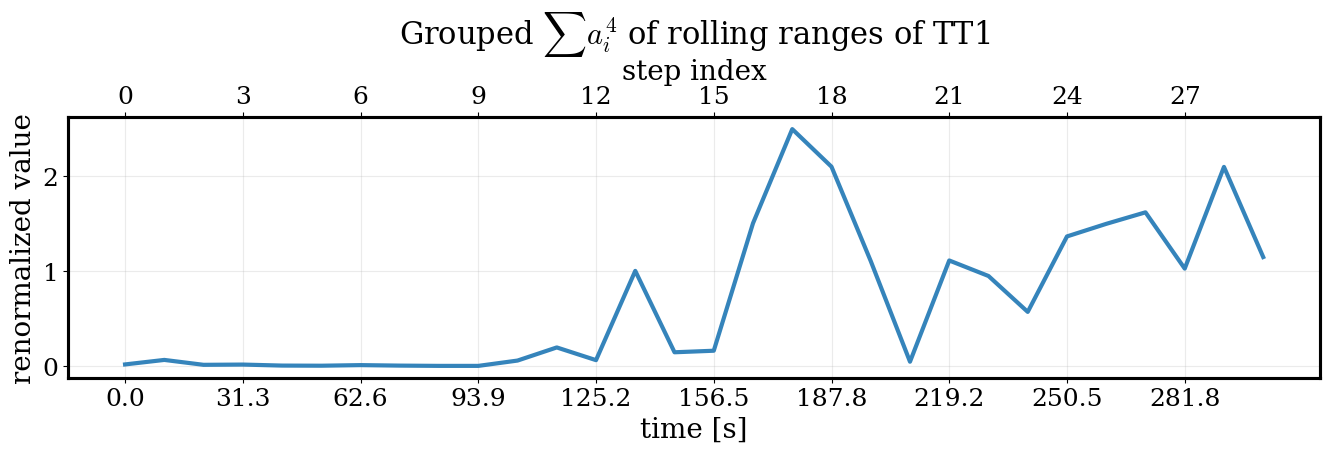

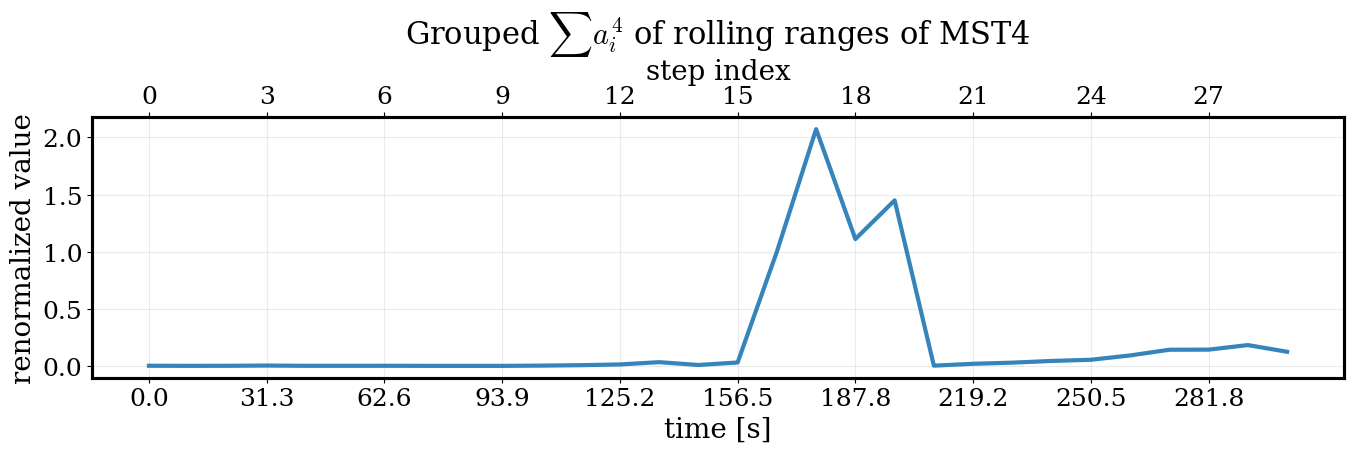

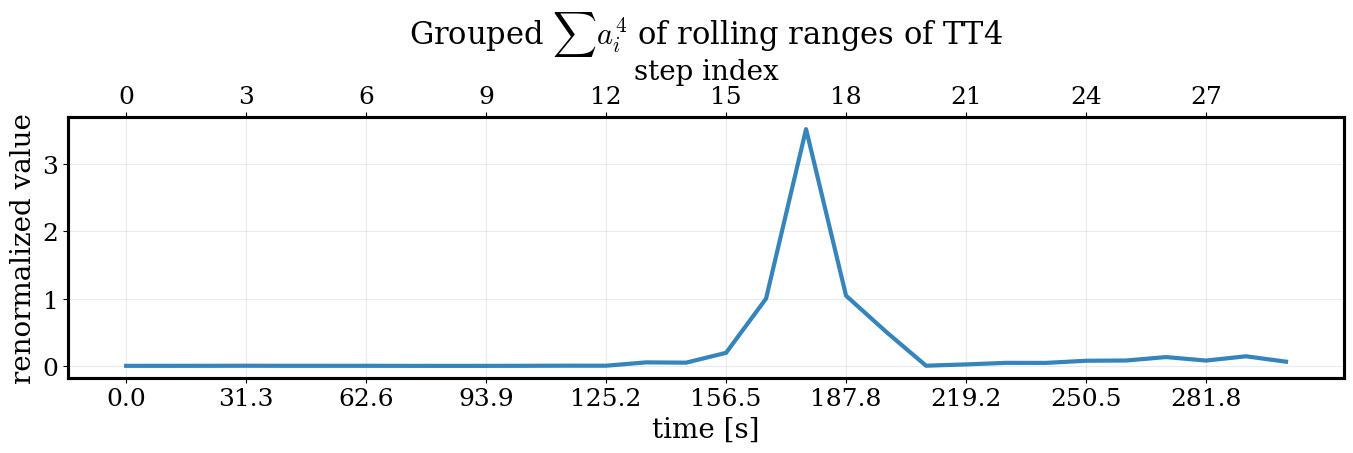

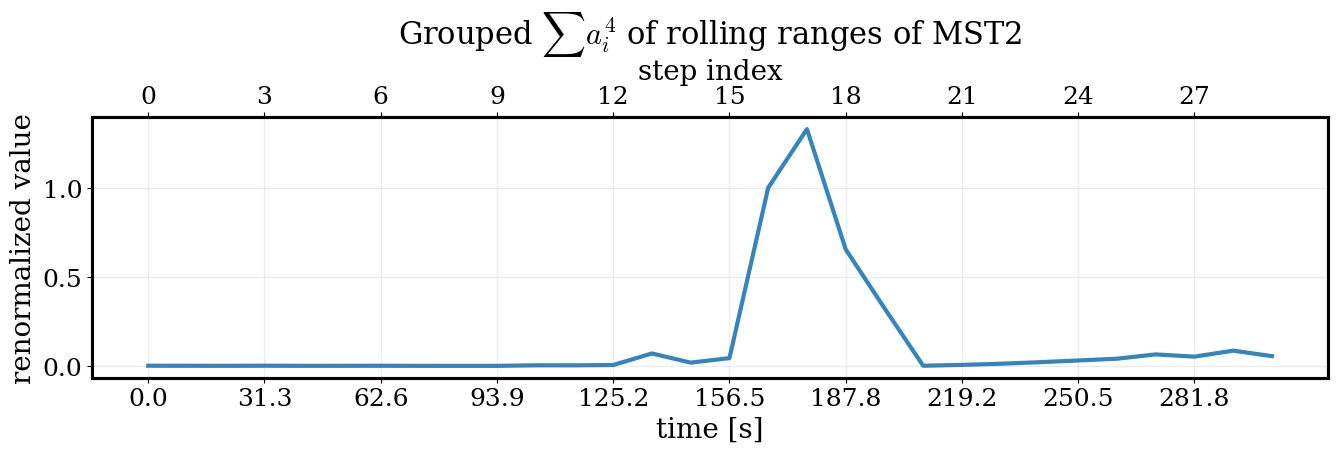

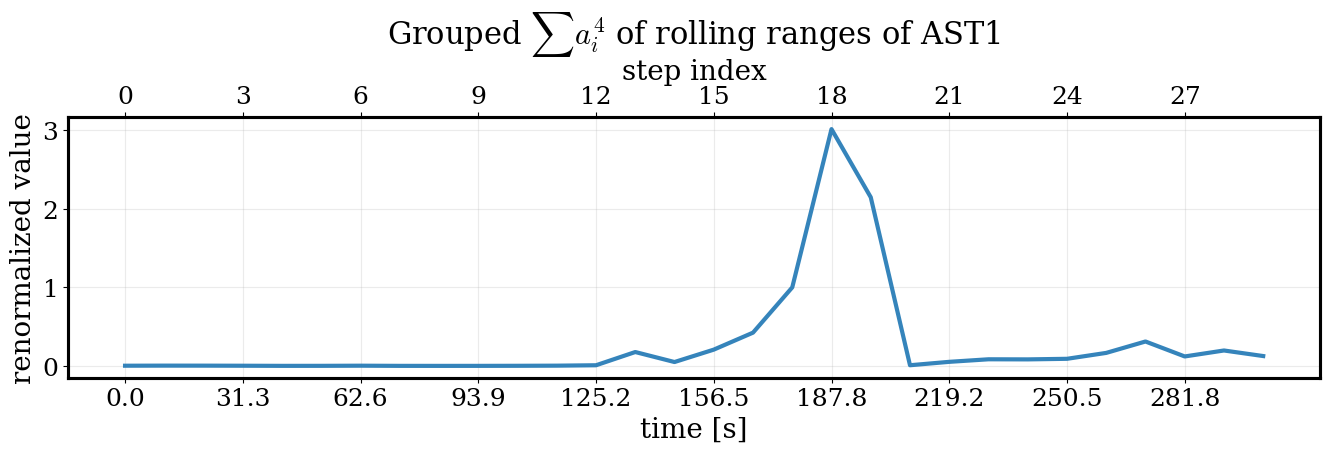

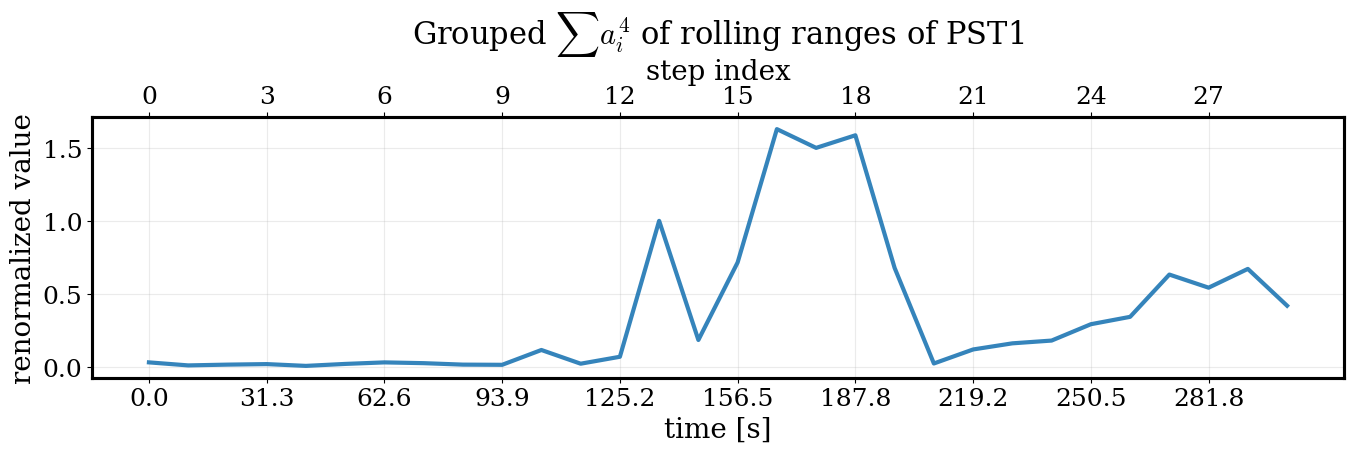

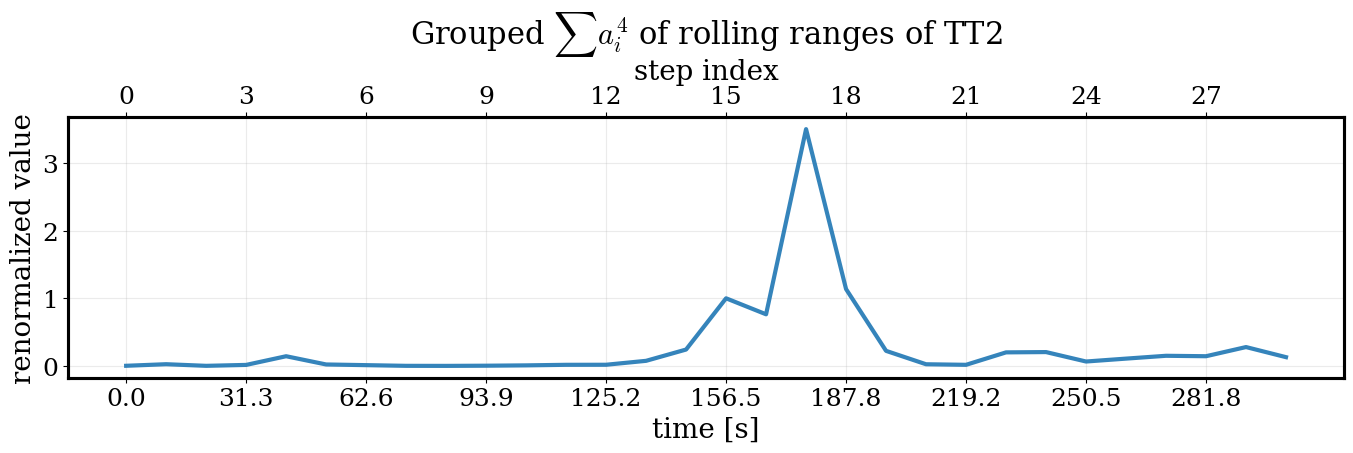

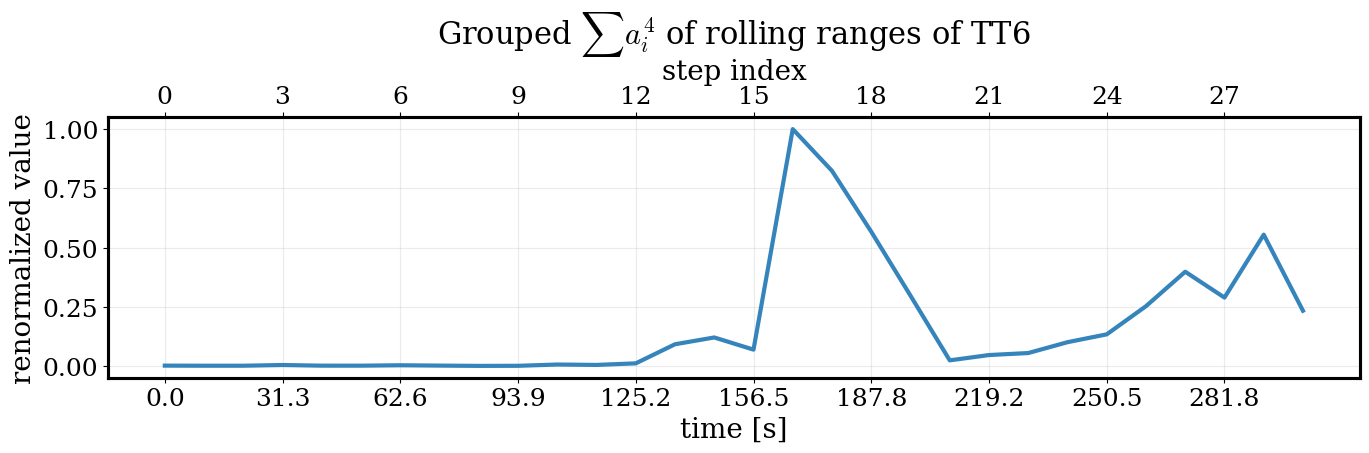

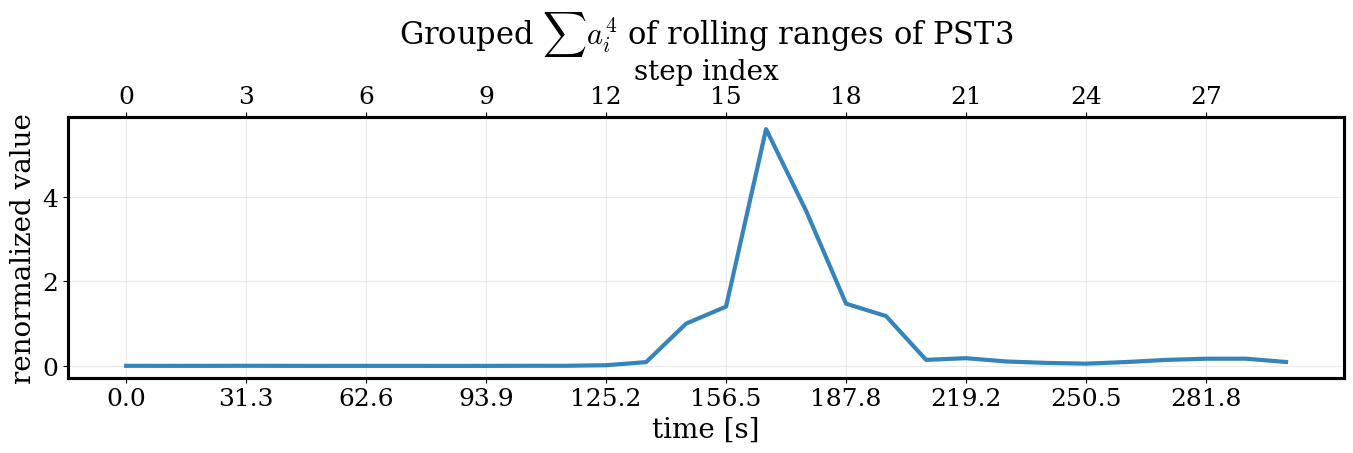

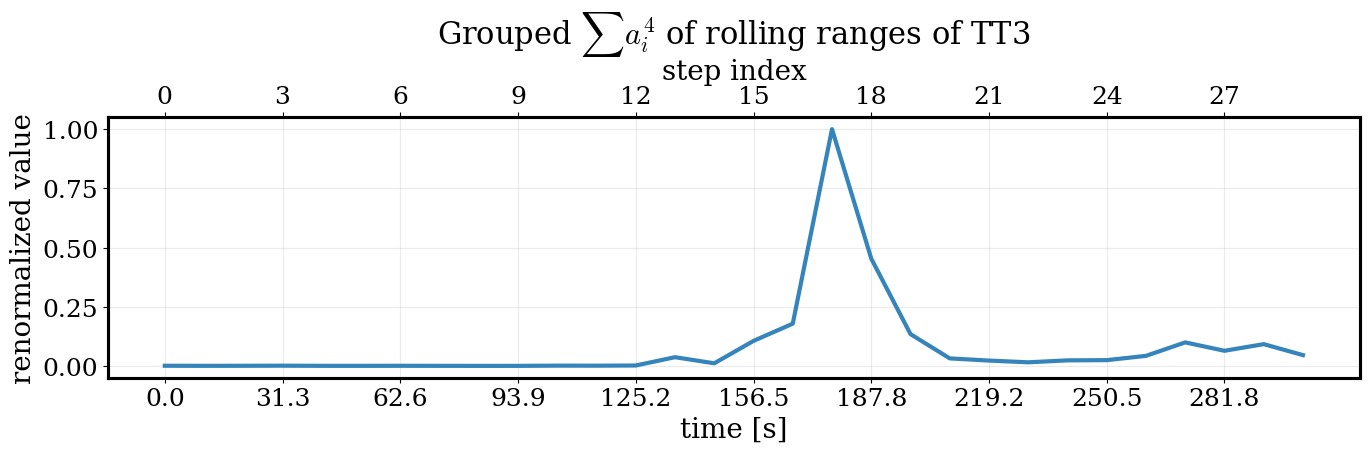

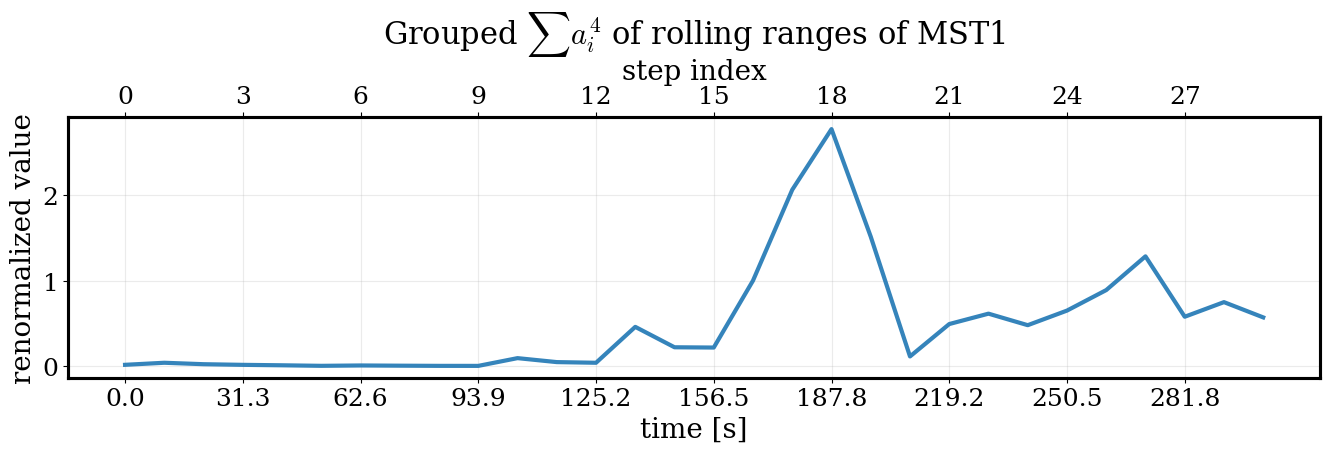

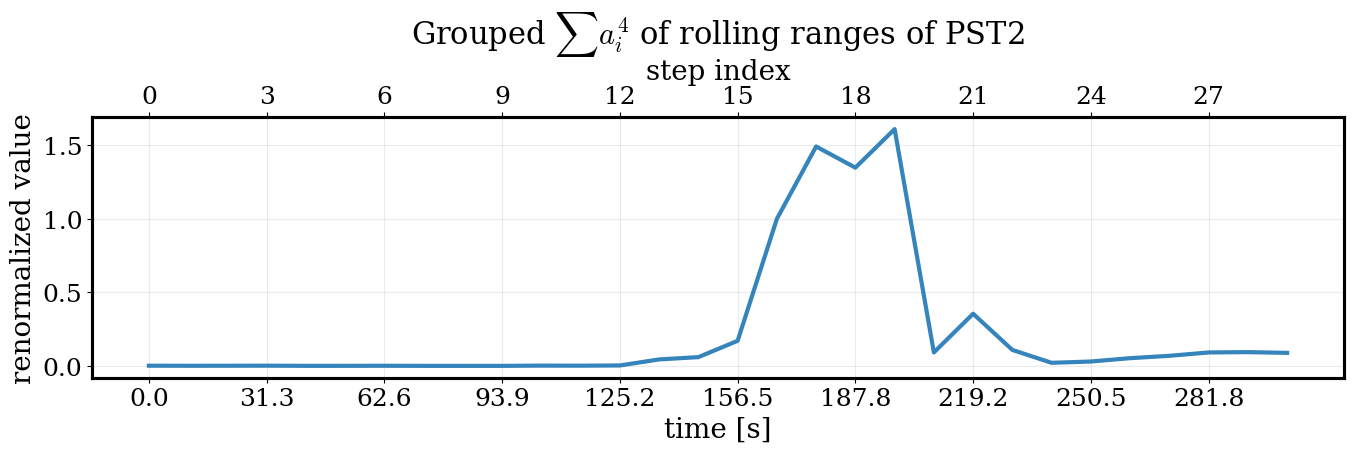

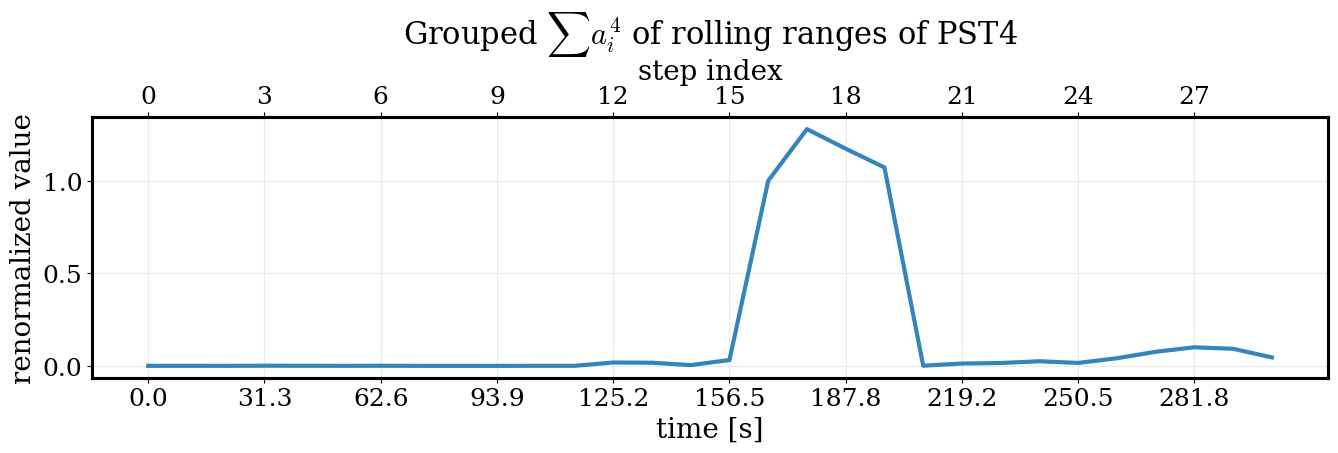

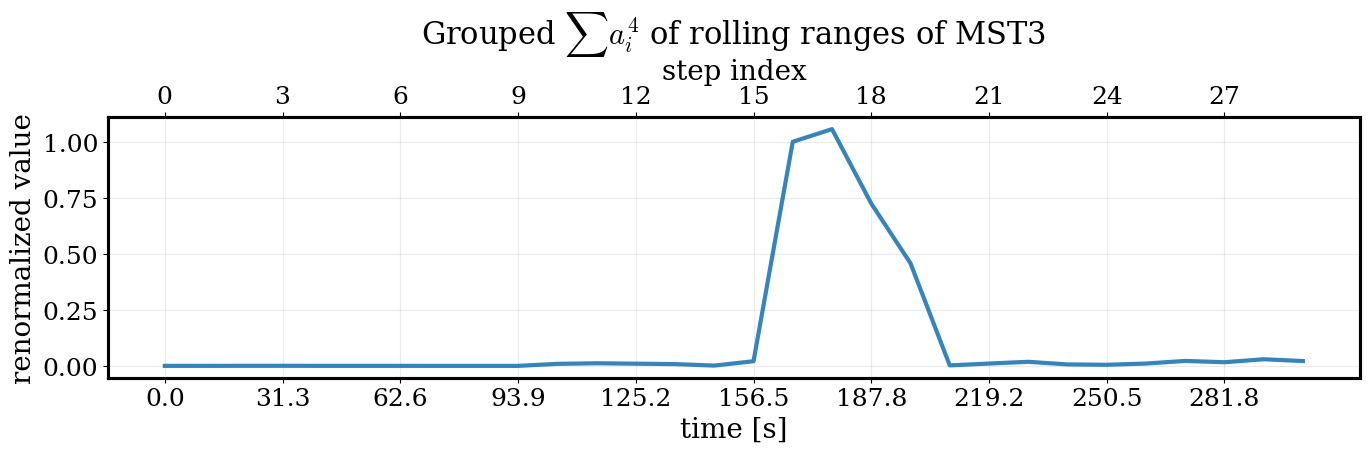

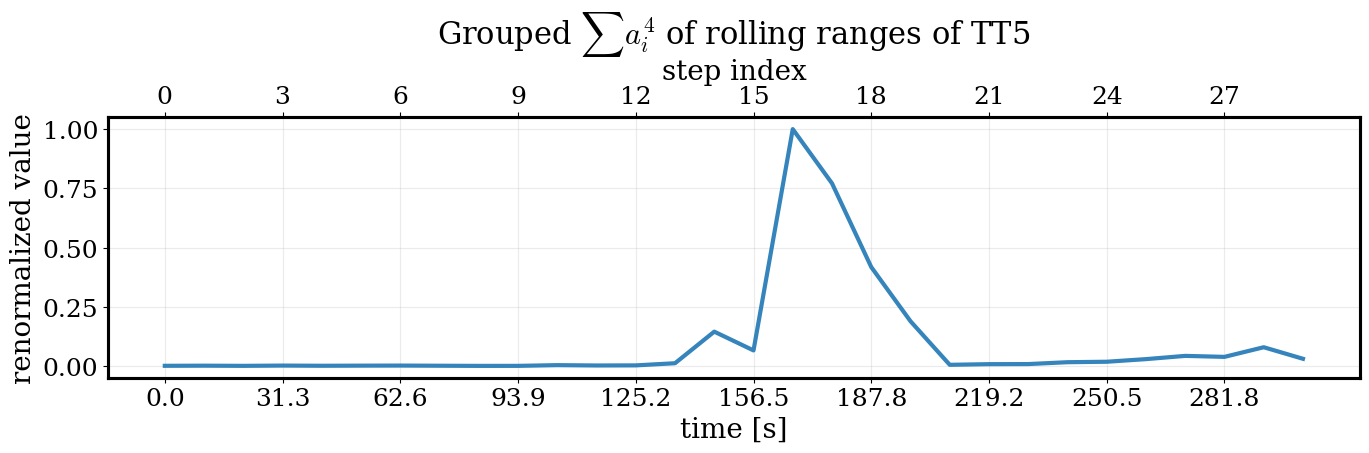

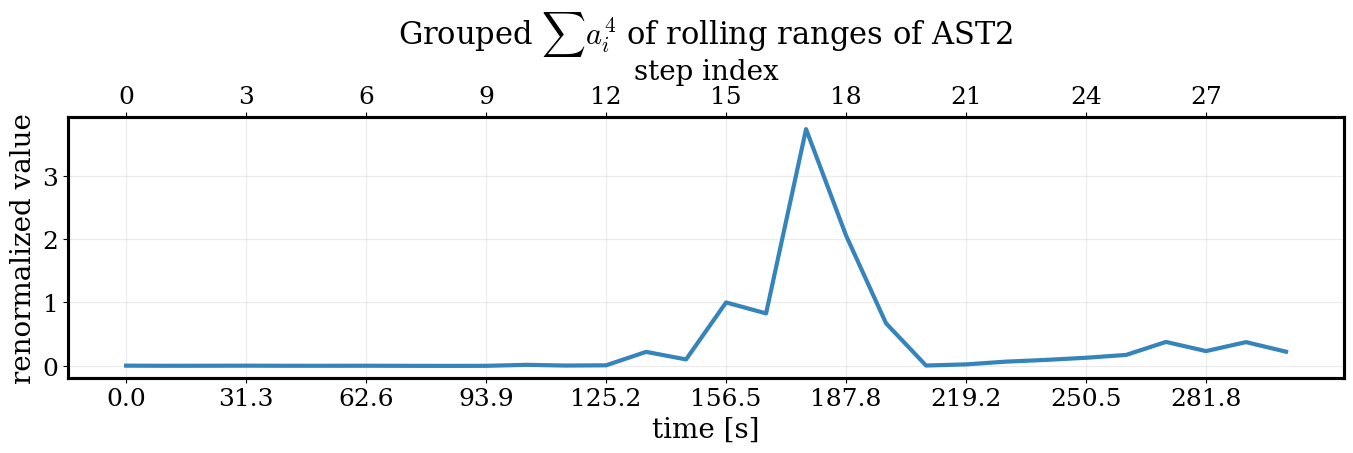

In [104]:
for i in range(signals_only.shape[0]):
    plot_roll(rolls, i)

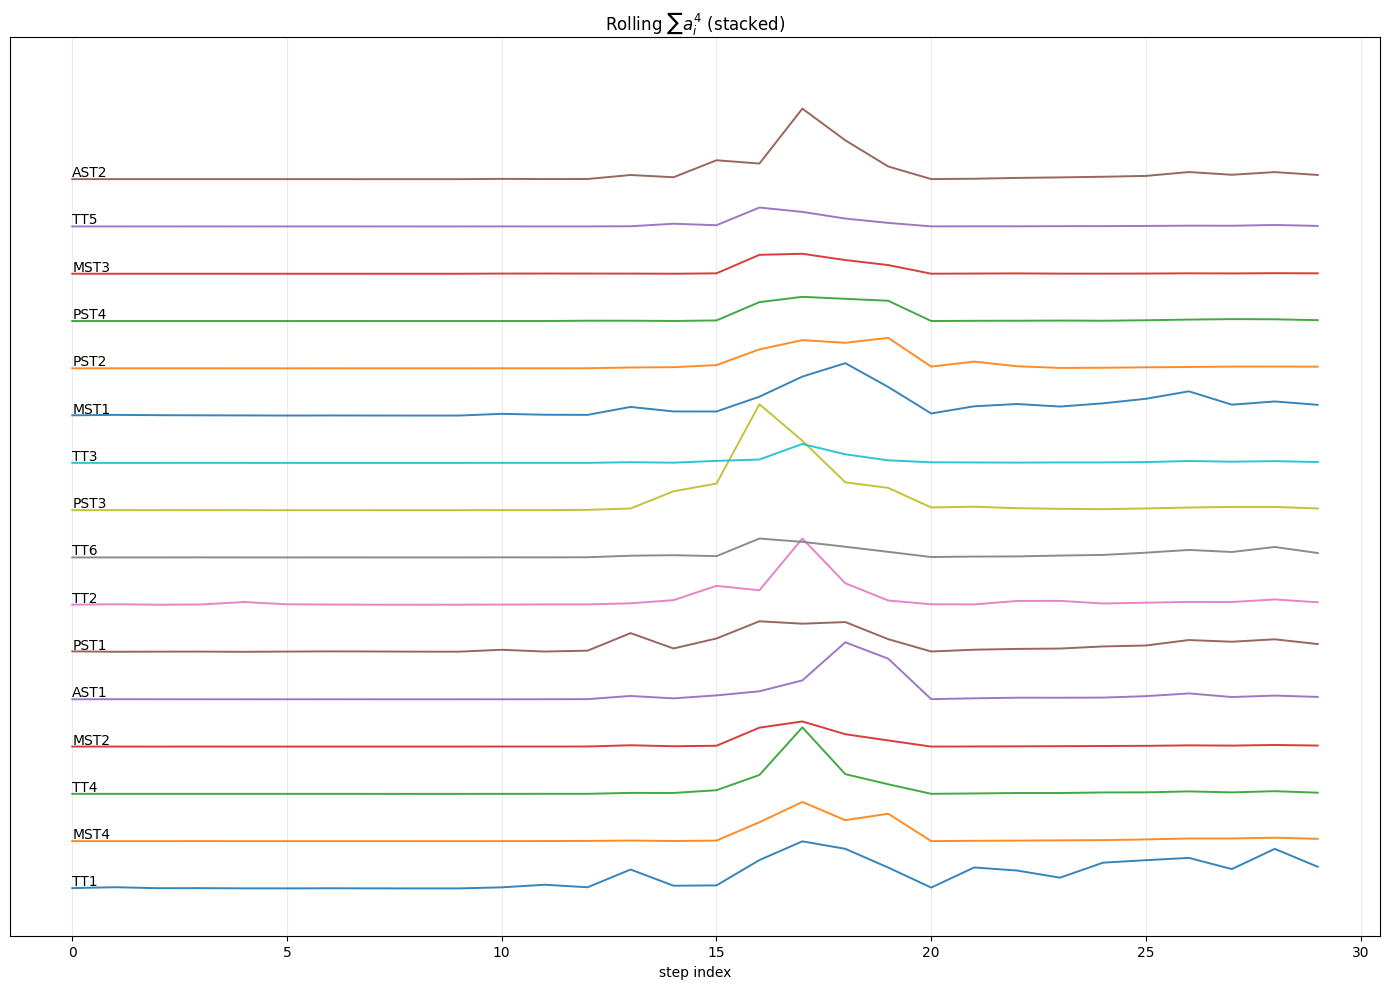

In [49]:
plt.figure(figsize=(14, 10))

gain = 0.02
spacing = .05

offset = 0
for i in range(signals_only.shape[0]):
    roll = np.array(rolls[i])
    roll_plot = gain * roll

    plt.plot(roll_plot + offset, alpha=0.9, linewidth=1.4)
    plt.text(0, offset, channel_names[i], va="bottom", fontsize=10)

    offset += spacing

plt.ylim(-spacing, offset+0.1)   # <-- CRUCIAL
plt.title(r"Rolling $\sum a_i^4$ (stacked)")
plt.xlabel("step index")
plt.yticks([])
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


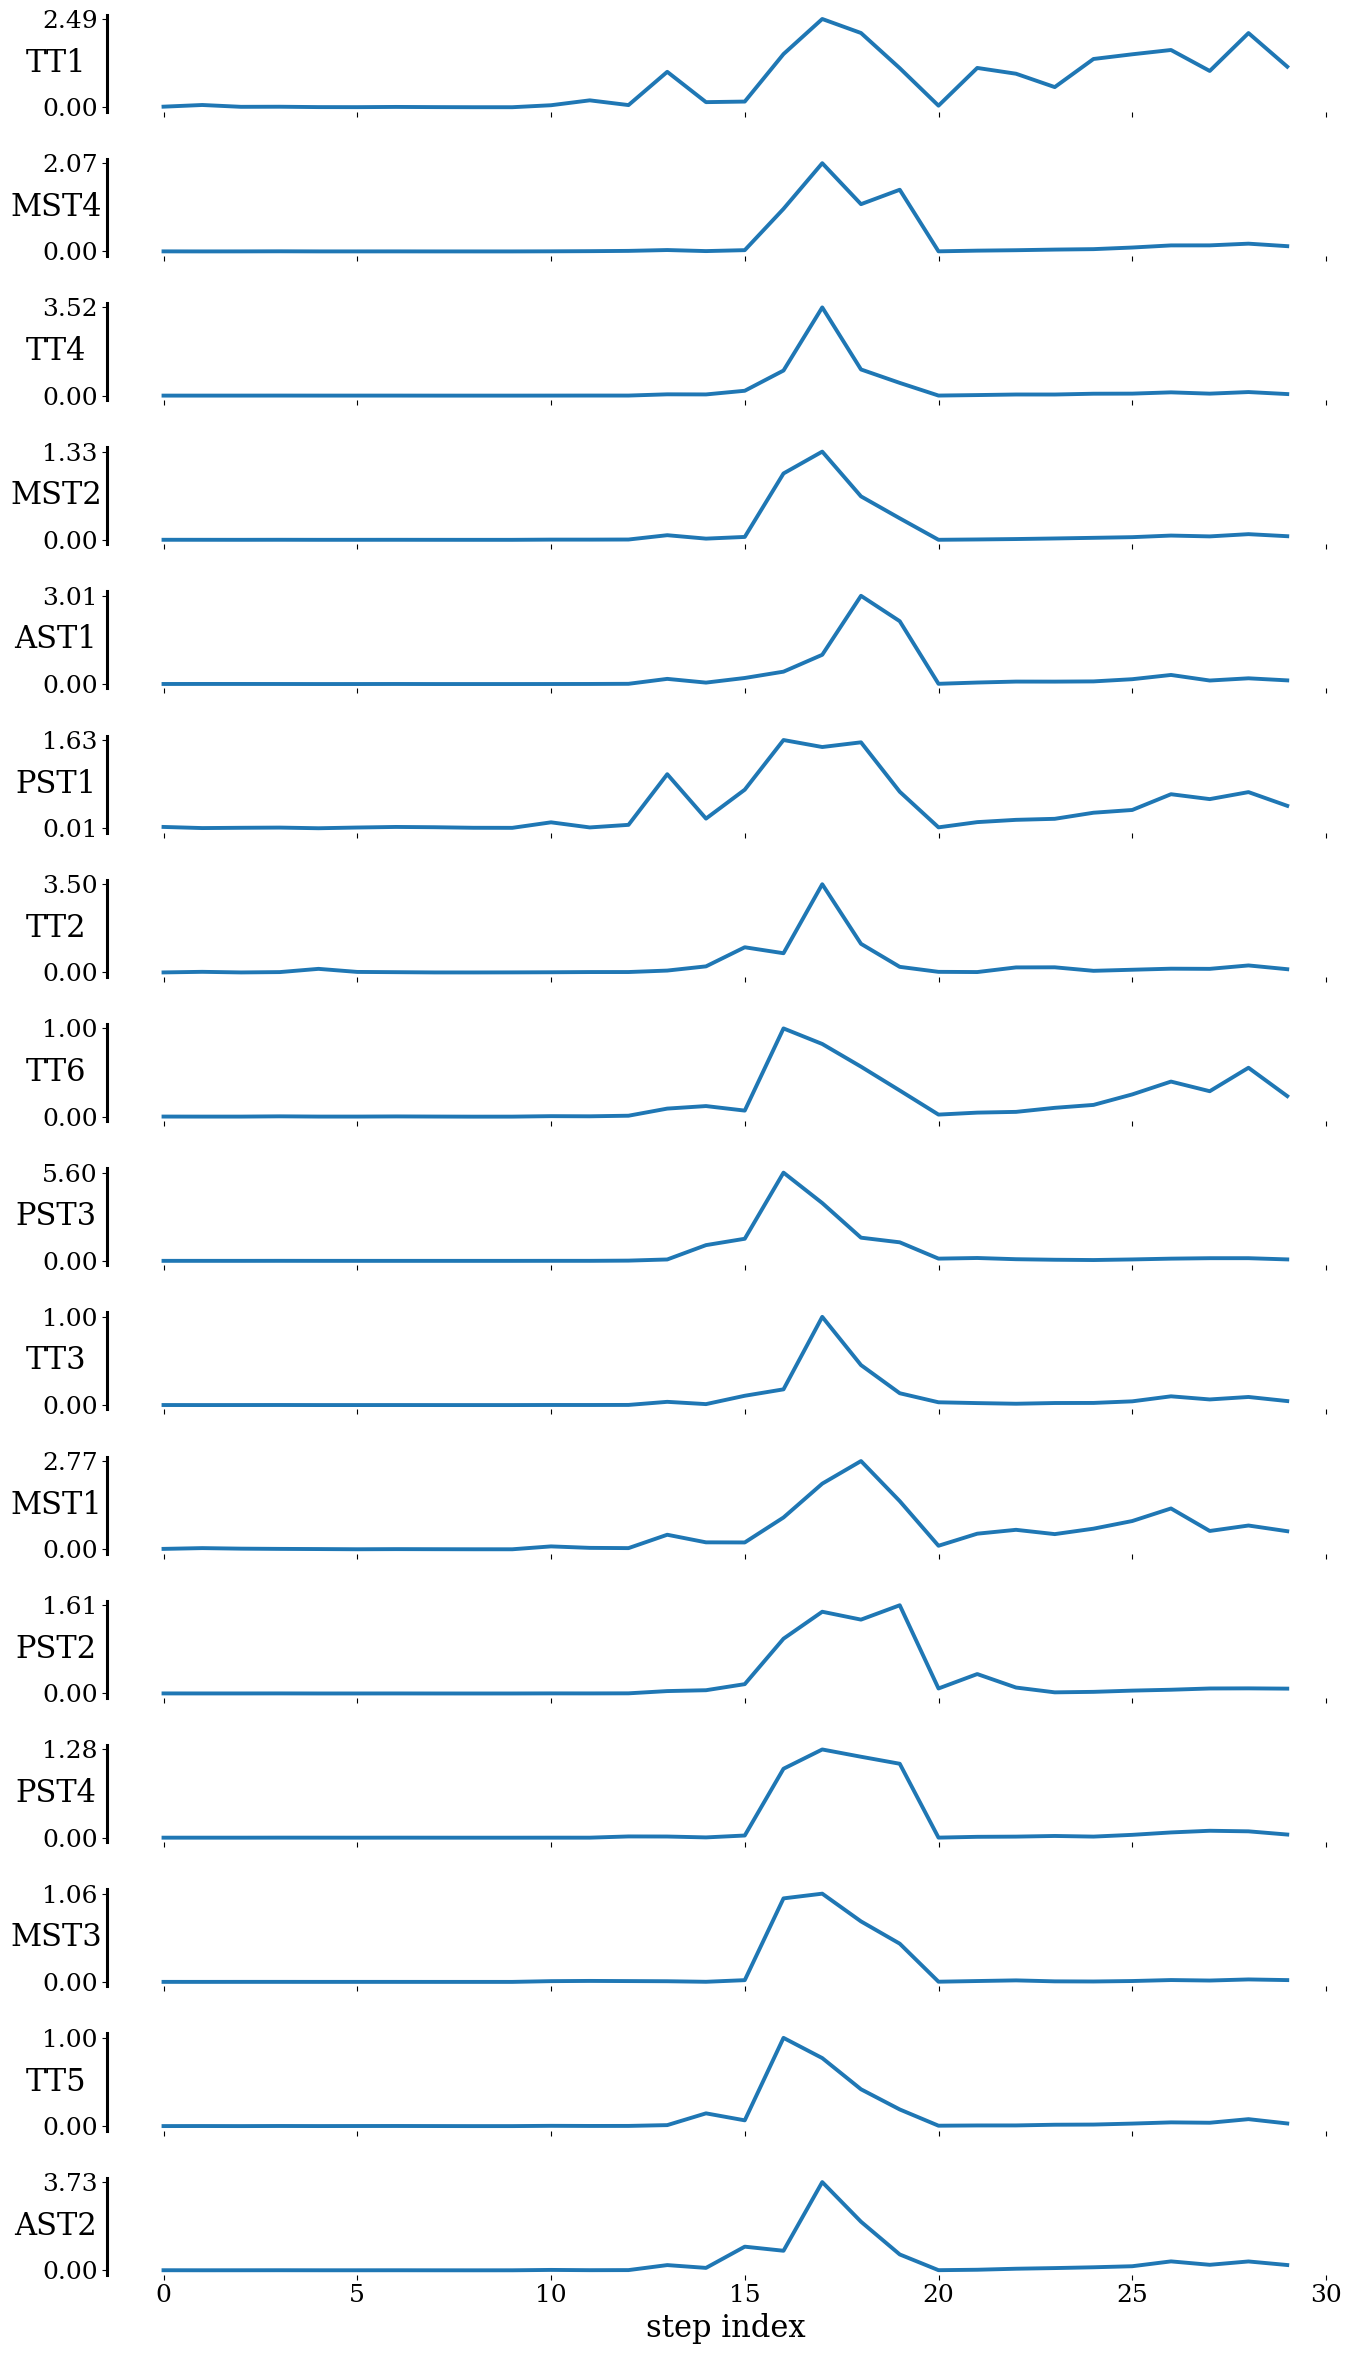

In [105]:
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
})

fig, axes = plt.subplots(
    signals_only.shape[0], 1,
    figsize=(14, 1.5*signals_only.shape[0]),
    sharex=True,
)
# plt.title(f'Rolling ')

for i, ax in enumerate(axes):
    roll = np.array(rolls[i])

    ax.plot(roll, linewidth=2.8)
    ax.set_ylabel(channel_names[i], fontsize=22, rotation=0, labelpad=-10,va="center")

    # only yticks at extremities
    ymin, ymax = np.min(roll), np.max(roll)
    ax.set_yticks([ymin, ymax])
    ax.set_yticklabels([f"{ymin:.2f}", f"{ymax:.2f}"], fontsize=12)

    ax.tick_params(axis="x", labelsize=18)
    ax.tick_params(axis="y", labelsize=18)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    # ax.spines["left"].set_visible(False)
    # ax.set_title(f'Rolling ')

    ax.grid(False)

axes[-1].set_xlabel("step index", fontsize=22)

plt.tight_layout()
plt.show()


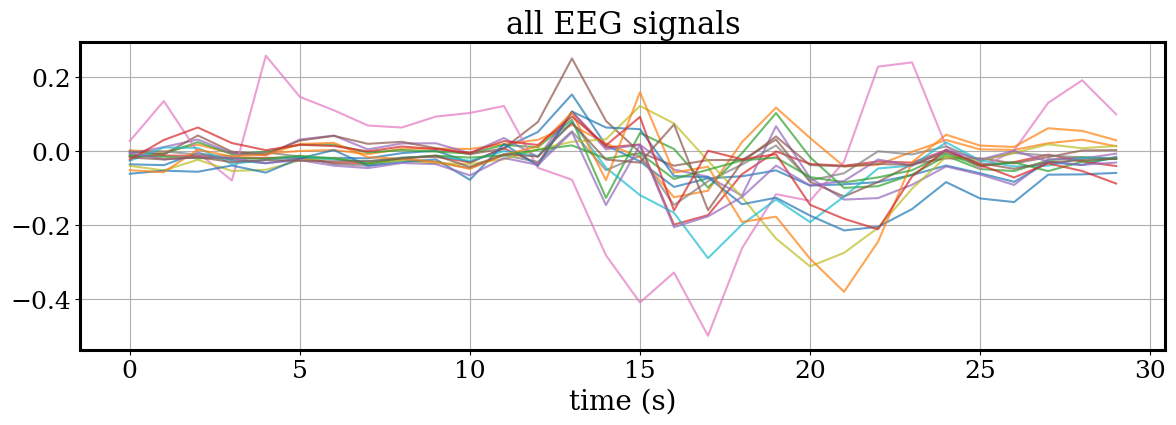

In [111]:
# almost the same lines as above
J_lists = []
jstep_length = signals_only.shape[1]//(steps)
for k in range(signals_only.shape[0]):
    rolling_sum4 = []
    for time in range(0,signals_only.shape[1] - jstep_length, jstep_length-1):
        # print(time)
        vector = signals_only[k, time:time+jstep_length]
        vector_norm = np.linalg.norm(vector) 
        if vector_norm == 0:
            rolling_sum4.append(0)
            continue
        vector = vector / vector_norm
        classical_sum4 = np.sum(vector)
        rolling_sum4.append(classical_sum4* vector_norm/50)  #division here 50 for more interesting Ising coefficient range
    J_lists.append(rolling_sum4) 
    

plt.figure(figsize=(14, 4))

for i, signal in enumerate(J_lists):
    # time = datensatz[:, 0]
    # signal = datensatz[:, 1]
    plt.plot(signal, label=f'{channel_names[i]}', alpha=0.7)

plt.title("all EEG signals")
plt.xlabel("time (s)")
# plt.legend(loc='upper right')
plt.grid(True)
plt.show()



In [171]:
import numpy as np
import matplotlib.pyplot as plt


def plot_roll_and_J_grouped(
    rolls,
    J_lists,
    step_length,
    times_only,
    channel_names,
    title_top=r"Grouped $\langle u^4\rangle$ rolling ranges (all channels) -> $h_{x,(k)}(t)$",
    title_bottom=r"Grouped EcoG (all channels) -> $J_k(t)$",
    normalize=True,
    cmap="tab20"
):

    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": 22,
        "axes.labelsize": 22,
        "axes.titlesize": 25,
        "xtick.labelsize": 22,
        "ytick.labelsize": 22,
        "axes.linewidth": 2.2
    })

    n_channels = len(rolls)
    cmap_obj = plt.get_cmap(cmap)
    colors = cmap_obj(np.linspace(0, 1, n_channels))

    fig, (ax1, ax2) = plt.subplots(
        2, 1,
        figsize=(16, 10),
        sharex=True
    )

    # -------------------
    # TOP: grouped rolls
    # -------------------
    for ch in range(n_channels):
        roll = np.array(rolls[ch])

        if normalize:
            roll = (roll - np.mean(roll)) / (np.std(roll) + 1e-12)

        ax1.plot(
            np.arange(len(roll)),
            roll,
            linewidth=2.5,
            alpha=0.99,
            solid_joinstyle="round",
            color=colors[ch],
            label=channel_names[ch]
        )

    ax1.set_ylabel("renormalized value" if normalize else "Renorm. value")
    ax1.set_title(title_top, pad=20)
    ax1.grid(True, alpha=0.25)

    # -------------------
    # BOTTOM: grouped J
    # -------------------
    for ch in range(n_channels):
        sig = np.array(J_lists[ch])

        if normalize:
            sig = (sig - np.mean(sig)) / (np.std(sig) + 1e-12)

        ax2.plot(
            np.arange(len(sig)),
            sig,
            linewidth=2.5,
            alpha=0.99,
            solid_joinstyle="round",
            color=colors[ch]
        )

    ax2.set_ylabel("renormalized value" if normalize else "Renorm. value")
    ax2.set_title(title_bottom)
    ax2.grid(True, alpha=0.25)

    # -------------------
    # Shared x-axis ticks
    # -------------------
    n_steps = len(J_lists[0])
    step_ticks = np.arange(0, n_steps, 3)

    ax2.set_xticks(step_ticks)
    idx = (step_ticks * step_length).astype(int)
    idx = np.clip(idx, 0, len(times_only[0]) - 1)

    time_labels = times_only[0][idx]
    ax2.set_xticklabels([f"{t:.1f}" for t in time_labels])
    ax2.set_xlabel("time [s]")

    # -------------------
    # Top axis (step index)
    # -------------------
    ax_top = ax1.twiny()
    ax_top.set_xlim(ax2.get_xlim())
    ax_top.set_xticks(step_ticks)
    ax_top.set_xticklabels([str(int(s)) for s in step_ticks])
    ax_top.set_xlabel("step index")

    ax_top.set_xlabel("step index", labelpad=15)

    # -------------------
    # Shared legend (right side)
    # -------------------
    handles, labels = ax1.get_legend_handles_labels()

    fig.legend(
        handles,
        labels,
        loc="center left",
        bbox_to_anchor=(0.86, 0.5),
        frameon=False,
    )

    plt.tight_layout(rect=[0, 0, 0.86, 1])
    plt.show()


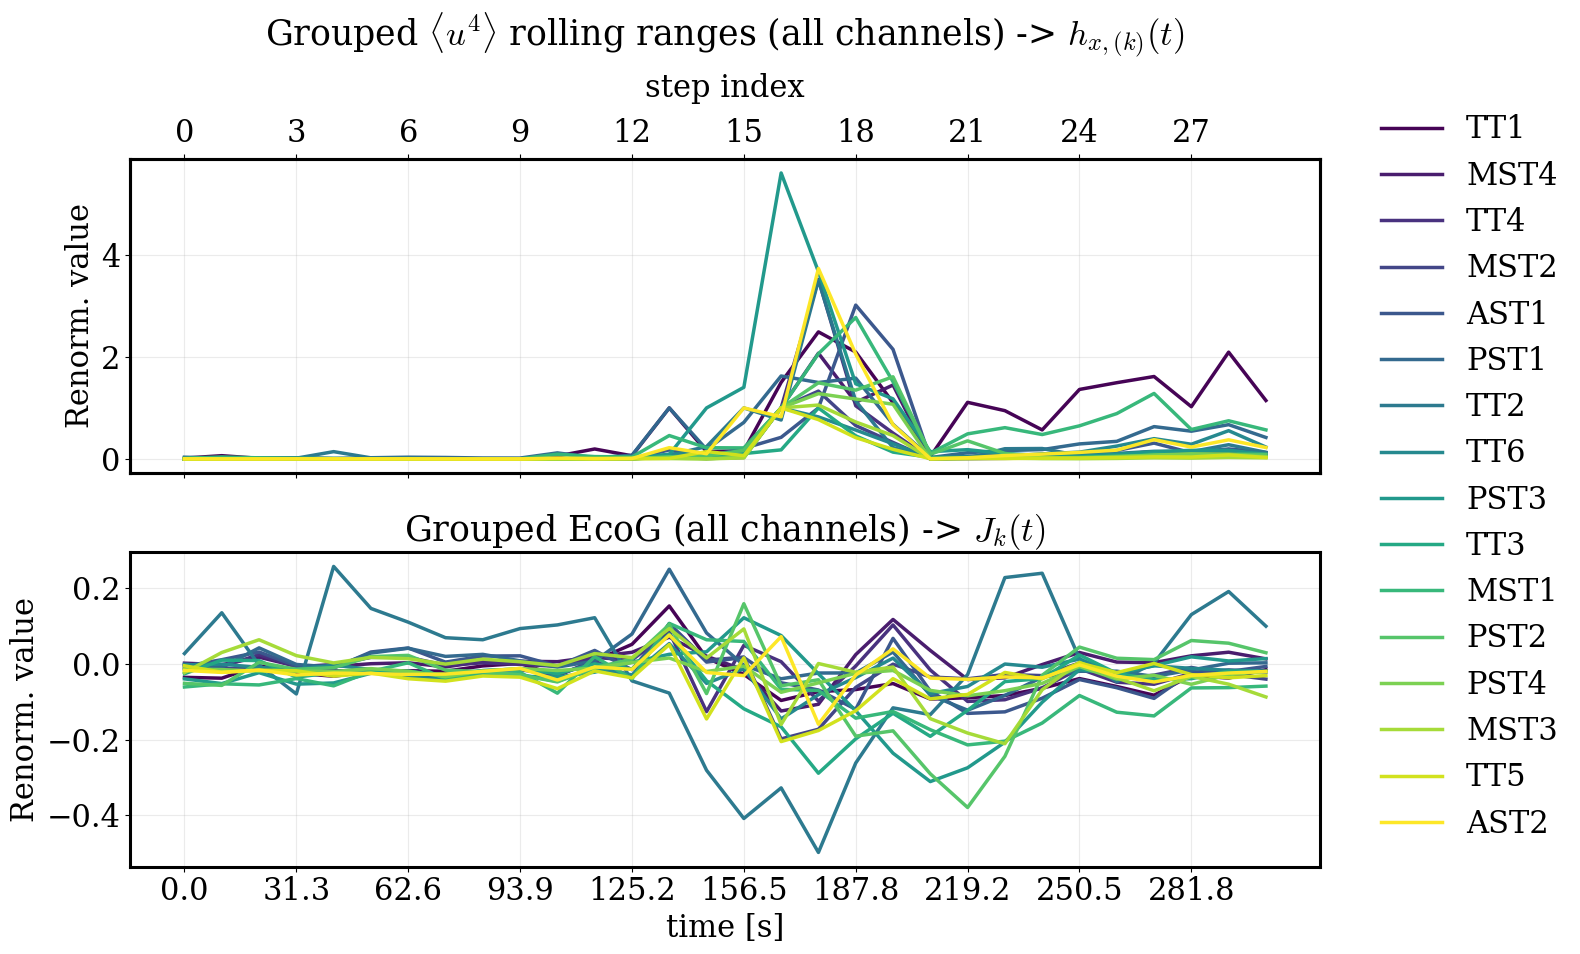

In [172]:
plot_roll_and_J_grouped(
    rolls=rolls,
    J_lists=J_lists,
    step_length=step_length,
    times_only=times_only,
    channel_names=channel_names,
    normalize=False,          # set False if you want raw values
    cmap="viridis"             # or "viridis", "Dark2", etc.
)


In [51]:
len(J_lists[0])

30

In [52]:

def time_evolution_Ising(N:int, J_list:list, hz_list:list, hx_list:list, dt:float) -> QuantumCircuit:
    # """
    
    
    # Time evolution circuit for the Ising model with open boudary conditions: H = \sum J_n * Z_n Z_{n+1} + \sum h_n * Z_n + \sum h_n * X_n
    # Args:
    #     N: number of qubits
    #     J_list: interacting couplings for each nearest neighbor
    #     hz_list: interacting couplings for Z_n for each qubit
    #     hx_list: interacting couplings for X_n for each qubit
    #     dt: time step
    # Returns:
    #     circ_dt: QuantumCircuit of the time evolution
    # """

    # print(f'number of qubits: {N}')
    q = QuantumRegister(N)
    circ_dt = QuantumCircuit(q)



    ## \PI_n exp(-it * J[n] * Z_n Z_{n+1})
    # n_eo_list: the orders for the two qubits gates, run the two-qubit gates of (n, n+1) for all even n in parallel; then  run the gates of (n, n+1) for all odd n
    n_eo_list = list(range(0, N-1, 2)) + list(range(1, N, 2))
    for n in n_eo_list:
        circ_dt.cx(q[n], q[(n+1)%N])
        circ_dt.rz(2*dt*J_list[n], q[(n+1)%N])
        circ_dt.cx(q[n], q[(n+1)%N])

    ## \PI_n exp(-it * hx[n] * X_n) exp(-it * hz[n] * Z_n)
    for n in range(N):
        circ_dt.rz(2*dt*hz_list[n], q[n])
        circ_dt.rx(2*dt*hx_list[n], q[n])

    # k = 0
    # for i in range(N):
    #     for j in range(i+1, N):
    #         circ_dt.cx(q[i], q[j])
    #         circ_dt.rz(2*dt*J_list[k], q[j])
    #         circ_dt.cx(q[i], q[j])
    #         k+=1


    return circ_dt

In [53]:
len(signals_only)

16

In [54]:
##INPUT PARAMS
N = len(signals_only)   ### number of qubits
dt = 0.5  ### time step
T =dt*steps  ### total running time

# n_qubits = len(signals_only)

backend = AerSimulator()

filename_preamble=f'patient{patientID}_data_seizure_{backend.name}'
path='./output'

In [55]:
def get_latest_index():
    files = os.listdir(path)
    pattr = re.compile(filename_preamble+r'_(\d+)')
    indexes = [int(pattr.match(file).group(1)) for file in files if pattr.match(file)]
    if len(indexes) == 0:
        return 0
    else:
        return max(indexes)


In [56]:
len(np.array(rolls)[0])

30

In [57]:
len(np.array(J_lists)[0])

30

In [58]:
### run
for r in range(1):



    tk_list = np.zeros((round(T/dt), N))  ### instore the color index list for each time slice
    #circ = initial_state_ry(N, C, k_list)   ### initial state encode 12 colors according to k_list

    circ = QuantumCircuit(N)
    circ_dt=[]
    for k in range(steps):
        print(k)
        hz_list=[0.0]*N
        hx_list=rolls[...,k]
        J_list=[x[k] for x in J_lists]
        # print(f'Hx: {hx_list}')
        # print(f'J: {J_list}')
        
        circ_dt.append(time_evolution_Ising(N, J_list, hz_list, hx_list, dt))
    ### start time evolution
    # print(circ_dt)
    # raise ValueError
    op_list = []
    for n in range(N):
        op_list.append(SparsePauliOp('I'*(N-n-1) + 'Z' + 'I'*n))

    circ = circ.compose(circ_dt[0])
    
    with Session(backend=backend) as session:
        countss = []
        pqca = []
        for step in tqdm(range(round(T/dt))):
            # print('step: ', step)
            t = round( dt * step )

            pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
            # print(circ.draw(output='text'))
            isa_circuit = pm.run(circ)
            s_circuit = isa_circuit.copy()
            s_circuit.measure_all()
            isa_observables = []
            for op in op_list:
                isa_observables.append(op.apply_layout(isa_circuit.layout))
            estimator = Estimator(mode=session)
            sampler = Sampler(mode=session)

            
            job = estimator.run([(isa_circuit, isa_observables)])
            
            job2 = sampler.run([s_circuit], shots=1000000)

            
            result = job.result()
            result2=job2.result()
            datas = []
            
            for n in range(N):              
                
                op_exp =result[0].data.evs[n]
                datas.append(result[0].data)
                k_tn = (1-op_exp)/2
                tk_list[step, n] =  k_tn


            
            countss.append(result2[0].data.meas.get_counts())
            pqca.append(list(result2[0].data.meas.get_counts().keys())[0])
            
            # print(k_tn)
            # print(result2[0].data.meas.get_counts())
            if step<round(T/dt)-1:
                # print(f'next_step: {step+1}')
                circ = circ.compose(circ_dt[step+1])
            # flat_sorted_indices = np.argsort(tk_list[step,:], axis=None)
            # tk_list[step,:] = flat_sorted_indices
            # print(f'tk_list: {tk_list[step,:]}')
        session.close()


    filename = f'{path}/{filename_preamble}_{get_latest_index() +1}_obs.txt'
    filename2 = f'{path}/{filename_preamble}_{get_latest_index() +1}_pqca_state.txt'

    # print(tk_list)
    for k in tk_list:
        with open(filename, 'a') as f:
            f.write(','.join(['{:0.4f}'.format(i) for i in k]) + '\n')
    with open(filename2, 'w') as f:
        for state in pqca:
            f.write(f"{state}\n")



    

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:49<00:00,  1.64s/it]


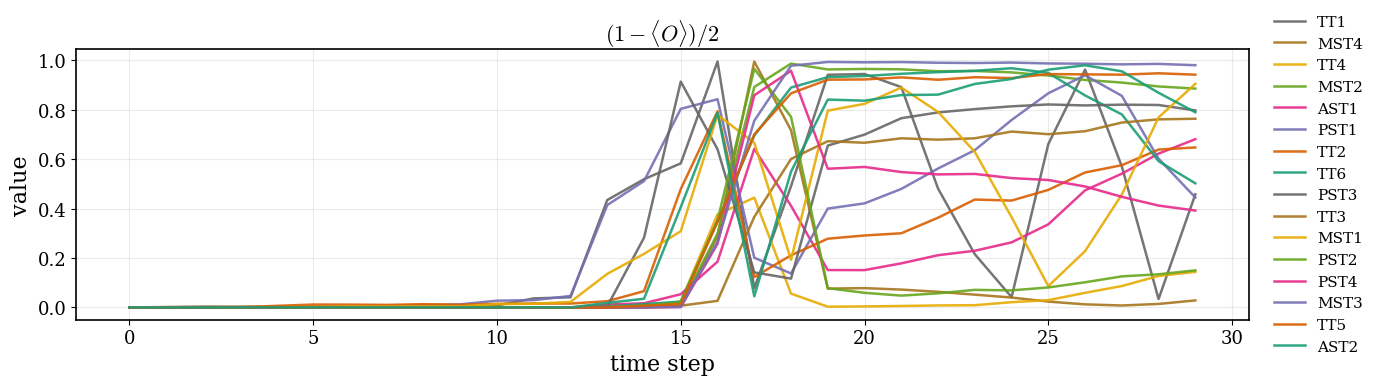

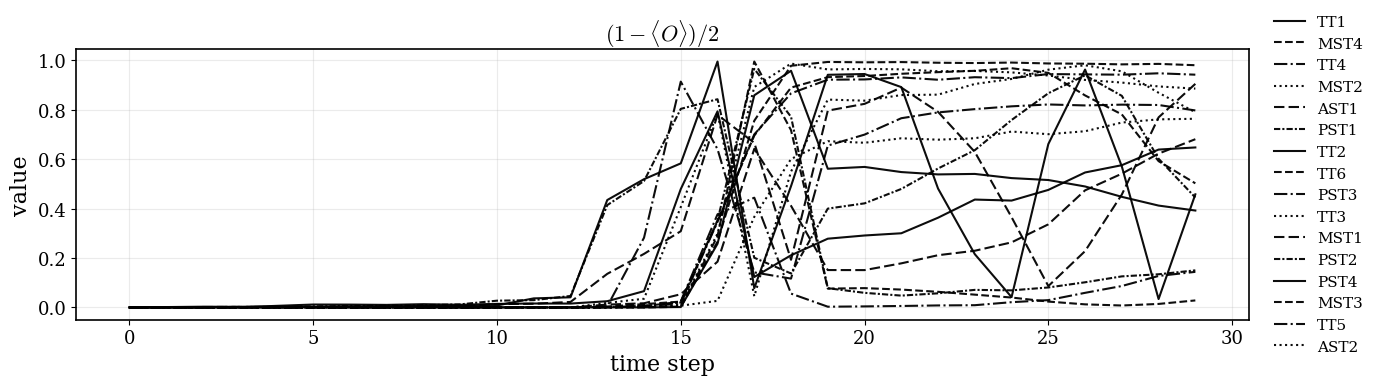

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def plot_observable_traces(tk_list, filenames, patientID=None, mode="color"):

    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": 14,
        "axes.labelsize": 16,
        "axes.titlesize": 16,
        "legend.fontsize": 11,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.linewidth": 1.2
    })

    fig, ax = plt.subplots(figsize=(14, 4))

    traces = np.transpose(tk_list)   # shape: (n_traces, T)
    n_traces = traces.shape[0]

    if mode == "color":
        cmap = plt.cm.Dark2_r
        linewidth = 1.8
        alpha = 0.9

        for i, signal in enumerate(traces):
            ax.plot(signal,
                    label=channel_names[i],
                    linewidth=linewidth,
                    alpha=alpha,
                    color=cmap(i % cmap.N))

    elif mode == "bw":
        linewidth = 1.5
        alpha = 0.95
        linestyles = ["-", "--", "-.", ":", (0, (5, 2)), (0, (3, 1, 1, 1))]

        for i, signal in enumerate(traces):
            ax.plot(signal,
                    label=filenames[i],
                    linewidth=linewidth,
                    alpha=alpha,
                    color="black",
                    linestyle=linestyles[i % len(linestyles)])

    else:
        raise ValueError("mode must be 'color' or 'bw'")

    ax.set_title(r'$(1 - \langle O \rangle)/2$')
    ax.set_xlabel("time step")
    ax.set_ylabel("value")

    ax.grid(True, alpha=0.25)

    # clean legend placement (outside)
    ax.legend(
        loc="center left",
        bbox_to_anchor=(1.01, 0.5),
        frameon=False
    )

    plt.tight_layout()

    if patientID is not None:
        plt.savefig(
            f"output/patient{patientID}_Trotter_observable_traces_{mode}.pdf",
            format="pdf",
            bbox_inches="tight"
        )

    plt.show()

    # return fig


# Example:
plot_observable_traces(tk_list, channel_names, patientID=patientID, mode="color")
plot_observable_traces(tk_list, channel_names, patientID=patientID, mode="bw")


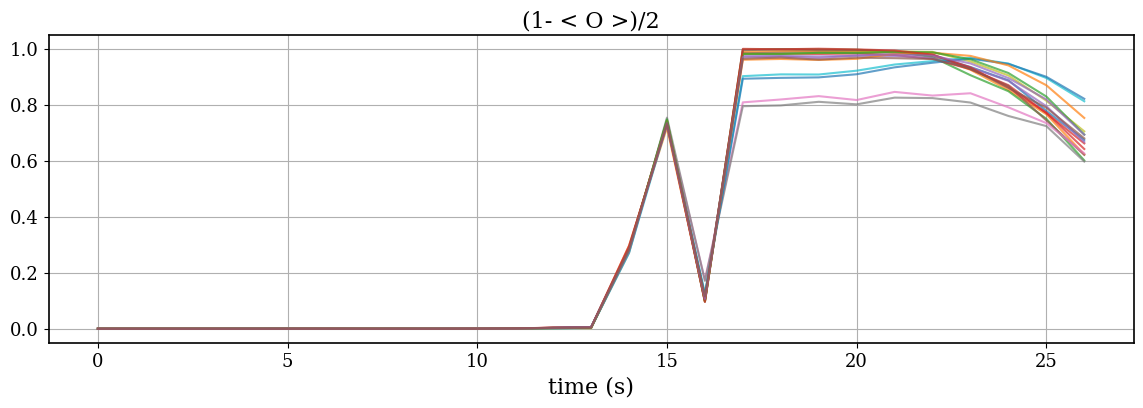

In [140]:
plt.figure(figsize=(14, 4))

for i, signal in enumerate(np.transpose(tk_list)):
    # time = datensatz[:, 0]
    # signal = datensatz[:, 1]
    plt.plot(signal, label=f'{channel_names[i]}', alpha=0.7)

plt.title("(1- < O >)/2")
plt.xlabel("time (s)")
# plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [31]:
import drawsvg
def sixteen_bits_to_squares(ten_bits):
    square_size = 20 # in pixels
    drawing = drawsvg.Drawing(square_size*16, square_size*9)
    for i, k in enumerate(ten_bits):
        for index, bit in enumerate(k):
            colour = '#000000' if int(bit) else '#eeeeee'
            rect = drawsvg.Rectangle(index*square_size,(i)*square_size,square_size,square_size, fill=colour)
            drawing.append(rect)
    return drawing

In [32]:
pqca # These are representative (not necessarily the most likely) states of a given iteration

['0000000000000000',
 '0000000000000000',
 '0000000000000000',
 '0000000000000000',
 '0100101100100001',
 '1111111100111111',
 '1110011111111111',
 '1110001111111111',
 '1101111110111101']

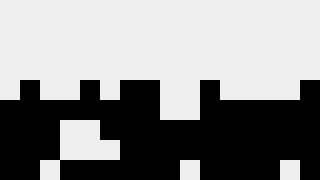

In [33]:
sixteen_bits_to_squares(pqca)

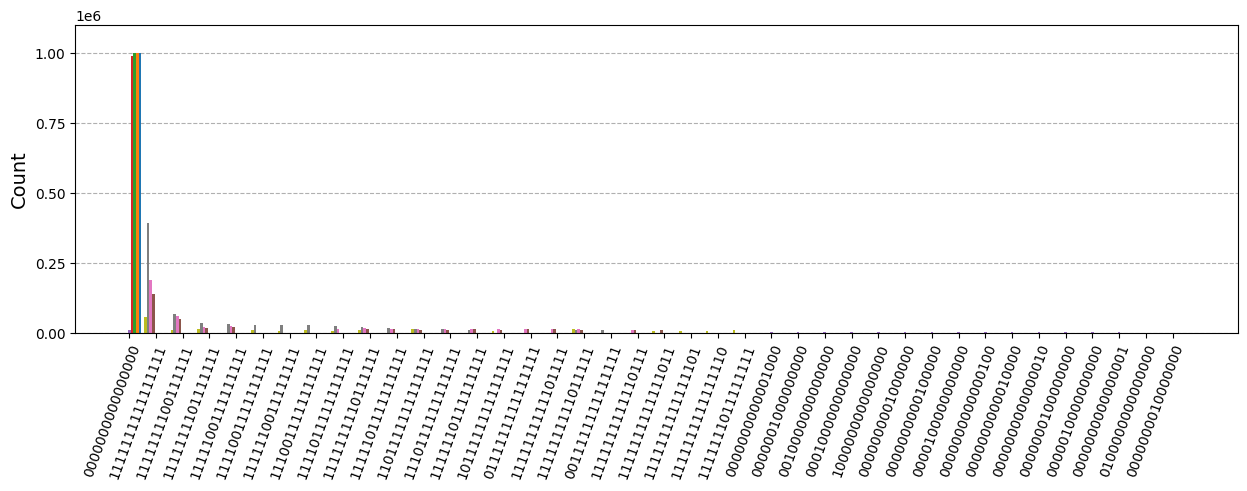

In [34]:
plot_histogram([x for x in countss],number_to_keep=15, bar_labels=False, sort='value_desc', figsize=(15,4))

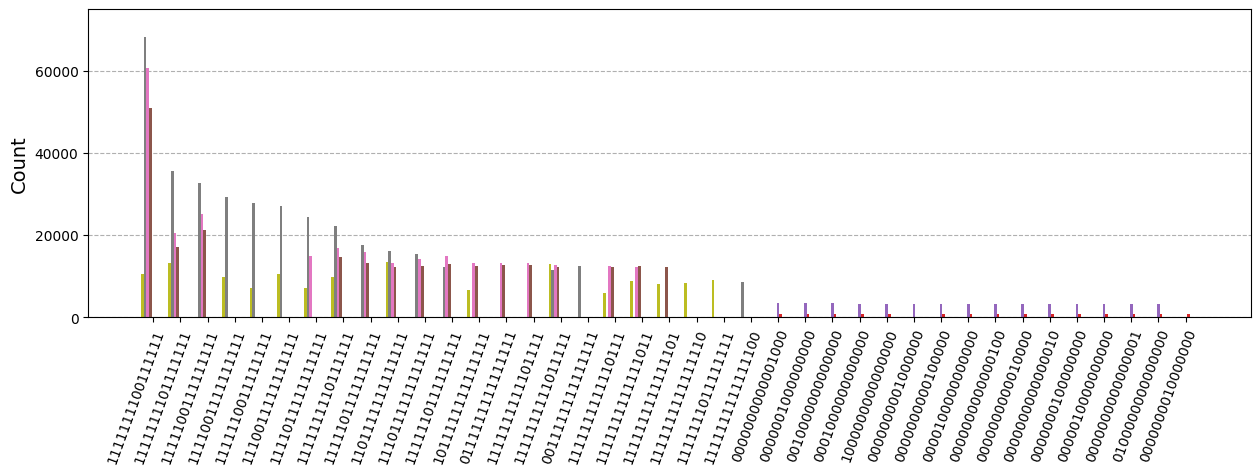

In [35]:
for c in countss:
    try:
        c.pop('0000000000000000') #Removing the o and 1 states for visualizaiton of the rest of the state
    except:
        pass
    try:
        c.pop('1111111111111111')
    except:
        pass
plot_histogram([x for x in countss],number_to_keep=15, bar_labels=False, sort='value_desc', figsize=(15,4))